# 15 LoopStack

In [1]:
# default_exp loopstack

In [2]:
# export
from forgebox.loop import Loop,ProgressBar,Tolerate,Event,Stuff
from types import MethodType
import numpy as np

In [3]:
from sklearn.datasets.california_housing import fetch_california_housing
x,y = fetch_california_housing(return_X_y = True)

x.shape, y.shape

((20640, 8), (20640,))

Normalized Data

In [4]:
def norm(m,s): return lambda x: (x-m)/s
def denorm(m,s): return lambda x: (x*s)+m

x_normed = norm(x.mean(0),x.std(0))(x)
y_normed = norm(y.mean(),y.std())(y)

In [5]:
x_normed.mean(0).astype(np.float16),x_normed.std(0),\
y_normed.mean().astype(np.float16),y_normed.std()

(array([ 0.,  0.,  0., -0., -0.,  0., -0., -0.], dtype=float16),
 array([1., 1., 1., 1., 1., 1., 1., 1.]),
 0.0,
 1.0)

Preview x input

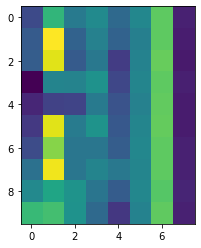

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(x_normed[np.random.choice(range(1000),10)])

In [7]:
# export
def create_event(event_name):
    class BatchEvent(Event):pass
    BatchEvent.__name__ = event_name
    return BatchEvent

def events(*enames):
    return list(map(create_event,enames))

In [20]:
# export
class LoopStack(Loop):
    settings = []
    """
    A stack of loop
    """
    @classmethod
    def from_loops(cls,*loops):
        def init(self,iterable=[],name = None):
            name = name if name!=None else cls.__name__
            
            self.loops = dict()
            l = Loop(iterable)
            for L in loops:
                l = L(iterable = l)
            super().__init__(iterable = l,
                             name = name)
            
            for stuff in cls.settings:
                self.make_stuff(stuff)
            
        setattr(cls,"__init__",init)
        return cls
    
    @classmethod
    def new_setting(cls,*settings):
        cls.settings+=list(settings)
    
    def make_stuff(self,name):
        new_stuff = Stuff(name)
        setattr(self.core,name,new_stuff)
        setattr(self,name,new_stuff)
    
    def __repr__(self,):
        return f"LoopStack>:{self.name}\n\t"+\
            "\n\t".join(map(str,self.core.layers[:-1]))

In [21]:
TRAIN_EVENTS = ["DATA_PROCESS","FORWARD","LOSS_CALC",
                "BACKWARD","OPT_STEP","METRICS"]
EVAL_EVENTS = ["DATA_PROCESS","EVAL_WRAP","FORWARD","LOSS_CALC","METRICS"]

In [22]:
# export 
class TrainLoop(LoopStack):
    def __init__(self,data_iter):
        self.from_loops(ProgressBar,Tolerate,
                        *events(*TRAIN_EVENTS))
        self.new_setting("model","opt","loss","hp","cuda")
        self.__init__(data_iter,)
        
        @self.on_DATA_PROCESS
        def opt_zero_grad(self):
            self.opt.zero_grad()
        
        @self.before_1st_FORWARD
        def switch_model_to_train(self):
            self.core.model = self.core.model.train()
            
class EvalLoop(LoopStack):
    def __init__(self,data_iter):
        self.from_loops(ProgressBar,Tolerate,
                        *events(*EVAL_EVENTS))
        self.new_setting("model","opt","loss","hp","cuda")
        self.__init__(data_iter,)
        
        @self.EVAL_FORWARD.downstream
        def torch_eval_wrap(self,func):
            with torch.no_grad():
                func()

In [23]:
loop = TrainLoop(range(50))
loop

LoopStack>:TrainLoop
	layer🍰Loop
	layer🍰ProgressBar
	layer🍰Tolerate
	event🌏DATA_PROCESS
	event🌏FORWARD
	event🌏LOSS_CALC
	event🌏BACKWARD
	event🌏OPT_STEP
	event🌏METRICS

In [ ]:
loop.model["baseline"]=

In [141]:
loop.summary()

KeyError: '❌🗝no key [forall]: in self.cases or self.funcs'

In [9]:
from time import sleep

In [10]:
@loop.on_DATA_PROCESS
def process_data(loop):
    sleep(.1)
    loop.core.double = loop.element*2
    
@loop.on_FORWARD
def update_pg(loop):
    loop.pgbar_description(f"double: {loop.double}")
    
@loop.on_FORWARD
def another_thing_on_forward(loop):
    loop.pgbar_data(dict(a=1))

In [11]:
loop.run()

In [12]:
loop.error_list()

[{'stage': 'start_cb',
  'i': -1,
  'epoch': 0,
  'error': AttributeError("'StorageCore' object has no attribute 'model'")},
 {'stage': 'iter_cb',
  'i': 0,
  'epoch': 0,
  'error': AttributeError("'StorageCore' object has no attribute 'opt'")},
 {'stage': 'iter_cb',
  'i': 1,
  'epoch': 0,
  'error': AttributeError("'StorageCore' object has no attribute 'opt'")},
 {'stage': 'iter_cb',
  'i': 2,
  'epoch': 0,
  'error': AttributeError("'StorageCore' object has no attribute 'opt'")},
 {'stage': 'iter_cb',
  'i': 3,
  'epoch': 0,
  'error': AttributeError("'StorageCore' object has no attribute 'opt'")},
 {'stage': 'iter_cb',
  'i': 4,
  'epoch': 0,
  'error': AttributeError("'StorageCore' object has no attribute 'opt'")},
 {'stage': 'iter_cb',
  'i': 5,
  'epoch': 0,
  'error': AttributeError("'StorageCore' object has no attribute 'opt'")},
 {'stage': 'iter_cb',
  'i': 6,
  'epoch': 0,
  'error': AttributeError("'StorageCore' object has no attribute 'opt'")},
 {'stage': 'iter_cb',
  'i':